In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [3]:
df = pd.read_parquet('cleaned/netflix_parquet')

Let us take a look at the dataframe we created after joining the movietitles and extracting the release year from the movie titles from the netflix prize dataset. You will notice the use of dictionaries which store the review data per movieId. 

We did this to decrease the memory usage the dataset is using, but also to include more movieids in a smaller sample. One movie contains multiple reviews, so taking more rows of the original dataset which is not grouped by movieId, would mean less different movieIds in a sample to train the recommender system with.

In the code, you will notice many functions/for loops which will unpack the dictionary to get ahold off the stored data.

In [4]:
# look at dataframe, first row and the dictionaries created during joining and merging the netflix prize dataset
df
df.iloc[0]
df['review_data'].iloc[0]

,movieId,year,title,review_data
0,1,2003,Dinosaur Planet,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
1,2,2004,Isle of Man TT 2004 Review,"[{'date': 2005-09-05, 'rating': 4.0, 'userId':..."
2,3,1997,Character,"[{'date': 2003-03-29, 'rating': 4.0, 'userId':..."
3,4,1994,Paula Abdul's Get Up & Dance,"[{'date': 2005-09-06, 'rating': 3.0, 'userId':..."
4,5,2004,The Rise and Fall of ECW,"[{'date': 2005-02-08, 'rating': 5.0, 'userId':..."
...,...,...,...,...
1428,13669,1988,Red Dwarf: Series 4,"[{'date': 2005-07-07, 'rating': 4.0, 'userId':..."
1429,13670,1997,White Badge,"[{'date': 2002-09-04, 'rating': 1.0, 'userId':..."
1430,13671,1967,Samurai Rebellion,"[{'date': 2005-11-28, 'rating': 4.0, 'userId':..."
1431,13672,1973,Kung Fu: Season 2,"[{'date': 2005-07-07, 'rating': 5.0, 'userId':..."


movieId                                                        1
year                                                        2003
title                                            Dinosaur Planet
review_data    [{'date': 2005-09-06, 'rating': 3.0, 'userId':...
Name: 0, dtype: object

array([{'date': datetime.date(2005, 9, 6), 'rating': 3.0, 'userId': '1488844'},
       {'date': datetime.date(2005, 5, 13), 'rating': 5.0, 'userId': '822109'},
       {'date': datetime.date(2005, 10, 19), 'rating': 4.0, 'userId': '885013'},
       {'date': datetime.date(2005, 12, 26), 'rating': 4.0, 'userId': '30878'},
       {'date': datetime.date(2004, 5, 3), 'rating': 3.0, 'userId': '823519'},
       {'date': datetime.date(2005, 11, 17), 'rating': 3.0, 'userId': '893988'},
       {'date': datetime.date(2004, 8, 5), 'rating': 4.0, 'userId': '124105'},
       {'date': datetime.date(2004, 4, 22), 'rating': 3.0, 'userId': '1248029'},
       {'date': datetime.date(2004, 5, 9), 'rating': 4.0, 'userId': '1842128'},
       {'date': datetime.date(2005, 5, 11), 'rating': 3.0, 'userId': '2238063'},
       {'date': datetime.date(2005, 5, 19), 'rating': 4.0, 'userId': '1503895'},
       {'date': datetime.date(2005, 6, 6), 'rating': 5.0, 'userId': '2207774'},
       {'date': datetime.date(2004, 8

So the dataset consists off the id, title, release year and corresponding reviews, where the userId, rating and date are appended in dictionaries. 

### Some general findings about Netflix Prize dataframe:

In [5]:
unique_users = set()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            unique_users.add(user_id)  # Add 'userId' to the set of unique user IDs

amount_of_reviews = list()  # Using a set to store unique user IDs

# Iterate over each row
for index, row in df.iterrows():
    # Iterate over each dictionary in the 'review_data' column of the current row
    for review_entry in row['review_data']:
        user_id = review_entry.get('userId')  # Extracting 'userId' from the dictionary
        if user_id:  # Check if 'userId' exists in the dictionary
            amount_of_reviews.append(user_id)  # Add 'userId' to the set of unique user IDs

print("There are {} reviews in our dataframe.".format(len(amount_of_reviews)))
print("There are {} unique users who have reviewed a movie.".format(len(unique_users)))

There are 7998454 reviews in our dataframe.
There are 449423 unique users who have reviewed a movie.


## What sample to take before doing EDA and creating the recommender system:

The complete dataset is handled above, from now on we will work with a representative sample to decrease memory usage and ease of use. The df dataframe will be randomly splitted into multiple samples with different sizes, with replacement(or with duplicates):

In [6]:
# make sample using random sampling:
sample_3quarter = df.sample(frac=3/4, random_state=42)
sample_half = df.sample(frac=1/2, random_state=42)
sample_third = df.sample(frac=1/3, random_state=42)
sample_quarter = df.sample(frac=1/4, random_state=42)
sample_sixth = df.sample(frac=1/6, random_state=42)
sample_tenth = df.sample(frac=1/10, random_state=42)
sample_25th = df.sample(frac=1/25, random_state=42)

# put them into a list for ease of use
sample_list = [df,sample_3quarter,sample_half,sample_third,sample_quarter,sample_sixth,sample_tenth,sample_25th]

### Let's define some functions so we can replicate our work for more samples easily:

In [7]:
import datetime
from scipy.stats import f_oneway

def get_month_name(month_num):
    return datetime.date(1900, month_num, 1).strftime('%B')

def extract_rating_date_plot_freq(df_list):
    for idx, df in enumerate(df_list):
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: 0 for month in range(1, 13)}
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                ratings_per_month[month] += 1

        months = list(ratings_per_month.keys())
        freq = list(ratings_per_month.values())
    
        plt.bar(months, freq, alpha=0.5, label=var_name)

    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.title('Frequency of Ratings per Month')
    plt.legend()
    plt.xticks(range(1, 13), [get_month_name(month) for month in range(1, 13)], rotation=90)  # Rotate x-axis labels
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
def extract_avg_rating_per_movie_and_plot(df_list, term):
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        avg_ratings = []
        for row in df['review_data'].values:
            ratings = [entry[term] for entry in row]
            avg_rating = np.mean(ratings)
            avg_ratings.append(avg_rating)  
        plt.hist(avg_ratings, bins=20, alpha=0.5, label=var_name)  # Adjust the number of bins as needed
    plt.xlabel('Average {}'.format(term))
    plt.ylabel('Frequency')
    plt.title('Distribution of Average {} per movie'.format(term))
    plt.legend()
    plt.show()

def extract_rating_anova(df_list):
    results = []
    for df in df_list:
        var_name = [name for name, value in globals().items() if value is df][0]
        ratings_per_month = {month: [] for month in range(1, 13)}
        total_ratings = 0
        for row in df['review_data'].values:
            for entry in row:
                month = entry['date'].month
                rating = entry['rating']
                ratings_per_month[month].append(entry['rating'])
                total_ratings += 1

        anova_data = [ratings_per_month[month] for month in range(1, 13)]
        f_statistic, p_value = f_oneway(*anova_data)
        results.append({'Sample': var_name, 'F-Statistic': f_statistic, 'P-value': p_value,'Amount of MovieIds':len(df),'Amount of Ratings': total_ratings})

    results_df = pd.DataFrame(results)
    results_df['Reject Null Hypotheses'] = results_df['P-value'] < 0.05

    return results_df

### Compare some key EDA findings to see wether the samples are representative:

Most column distributions were highly skewed, which indicates that it is not promising to compare that for multiple samples, as the result will be very likely to be the same. Results such as the normality of ratings and the anova results are most important. We will look at those for different samples:

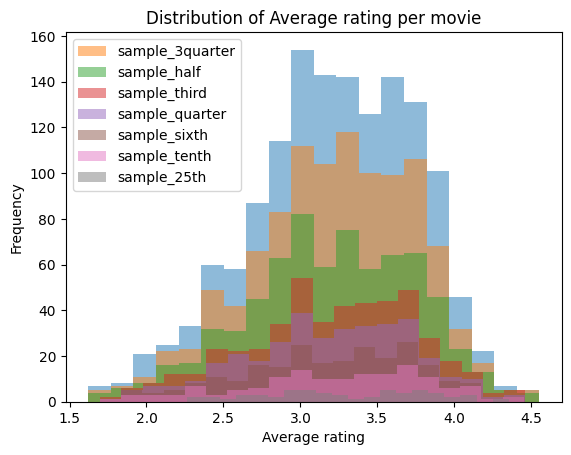

In [8]:
extract_avg_rating_per_movie_and_plot(sample_list, 'rating')

Distribution of avg. ratings is still normally distributed when the sample size is reduced.

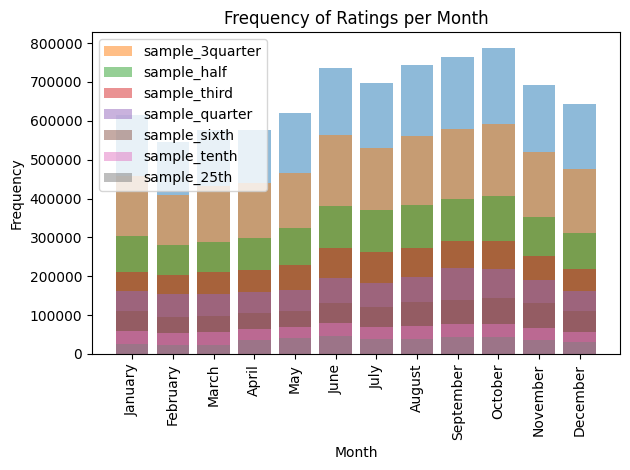

In [9]:
extract_rating_date_plot_freq(sample_list)

Distribution of amount of reviews per month do not show massive differences when the sample size is reduced.

In [10]:
extract_rating_anova(sample_list)

,Sample,F-Statistic,P-value,Amount of MovieIds,Amount of Ratings,Reject Null Hypotheses
0,___,229.170934,0.000000e+00,1432,7998454,True
1,sample_3quarter,241.220247,0.000000e+00,1074,6030151,True
2,sample_half,147.801516,0.000000e+00,716,4102649,True
3,sample_third,137.227510,3.411732e-317,477,2928433,True
4,sample_quarter,127.331318,1.093321e-293,358,2165599,True
5,sample_sixth,98.708894,7.955484e-226,239,1435047,True
6,sample_tenth,116.658118,3.057043e-268,143,799645,True
7,sample_25th,174.074455,0.000000e+00,57,423391,True


The complete dataset, but also three quarter and 25th of the dataset show a p-value of 0, meaning that those sample sizes are too large or small to detect differences across groups of months of the year with relation to avg. rating. A third, quarter, sixth and tenth of the total sample size would be representative to use, as those show a p-value which is lower than alpha and they are not 0. Therefore, those samples are able to show differences across groups.

### Overall conclusion:

Most important EDA findings do not seem to change when you increase or decrease the sample size. At the same time, ANOVA results of each sample showed that only a couple of sample sizes are suitable to highlight differences across groups. Those sample sizes can be considered to feed to the recommender system to train.

## Let's look into the columns more deeply:
### When were the most movies released?

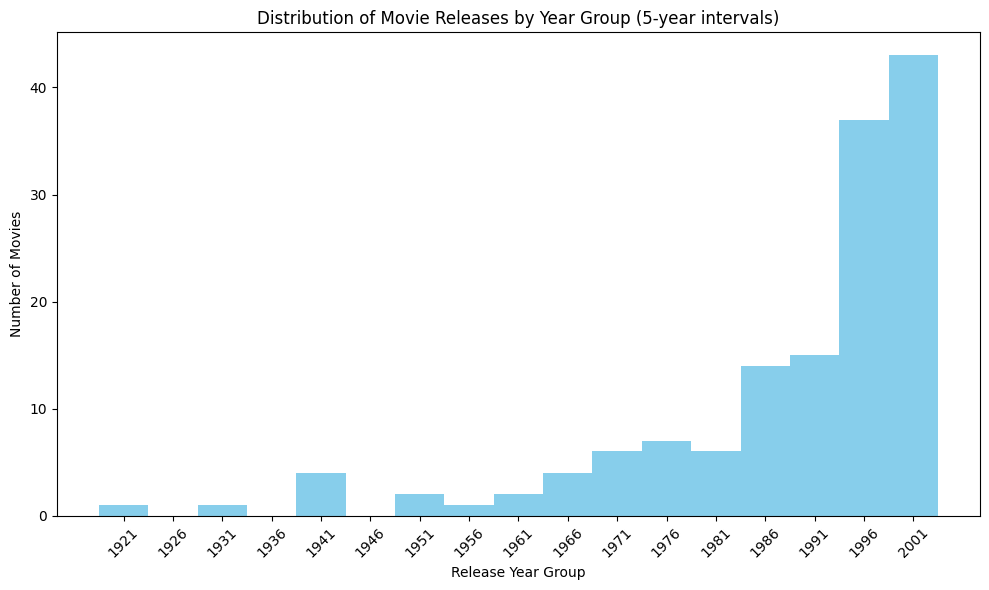

In [11]:
# Define the bin size in years
bin_size = 5

# Extract release years from the 'release_year' column
release_years = (sample_tenth['year'].astype(int)).tolist()

# Calculate the minimum and maximum release years to determine the range
min_year = min(release_years)
max_year = max(release_years)

# Initialize dictionary to store counts for each bin
bin_counts = {}

# Count the occurrences of each release year within the corresponding bin
for year in release_years:
    bin_index = (year - min_year) // bin_size
    bin_start_year = min_year + bin_index * bin_size
    if bin_start_year in bin_counts:
        bin_counts[bin_start_year] += 1
    else:
        bin_counts[bin_start_year] = 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(bin_counts.keys(), bin_counts.values(), color='skyblue', width=bin_size)
plt.xlabel('Release Year Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Releases by Year Group ({}-year intervals)'.format(bin_size))
plt.xticks(range(min_year, max_year + 1, bin_size), rotation=45)
plt.tight_layout()
plt.show(); # to dont export text output

Seems like most movies have been released around the 90s and the 00s in the dataset.

### When were the most ratings placed?

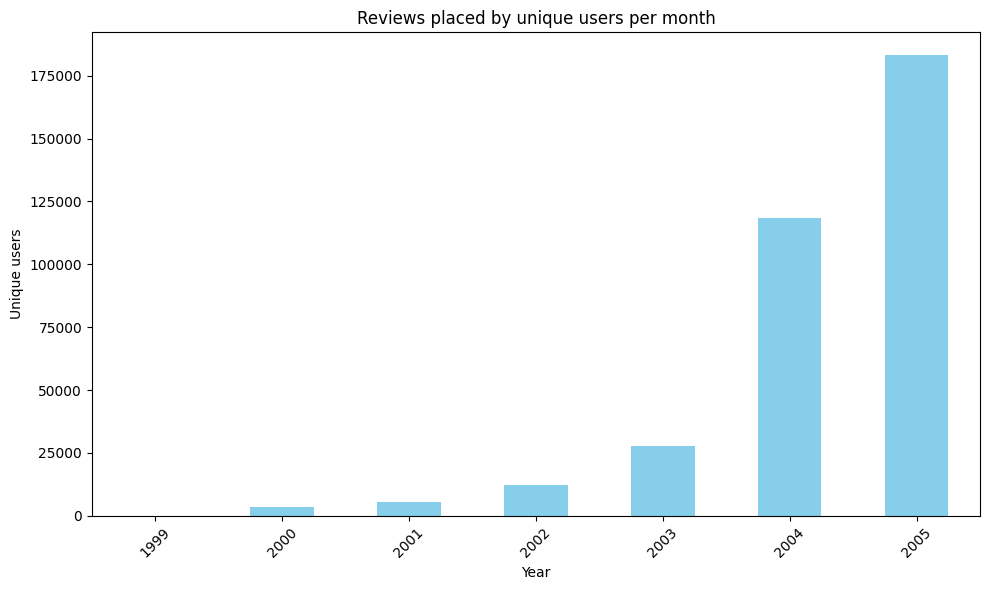

In [12]:
# Extract review dates and user IDs using NumPy
review_data = sample_tenth['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Create a DataFrame with review dates and user IDs
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids})

# Group reviews by month and count the number of unique users for each month
yearly_unique_users = review_df.groupby(review_df['Date'].dt.to_period('Y'))['User_ID'].nunique()

# Plot the number of unique users by month
plt.figure(figsize=(10, 6))
yearly_unique_users.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unique users')
plt.title('Reviews placed by unique users per month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In 2005, most movies were reviewed by unique users.

### On which days of the week most reviews were placed?

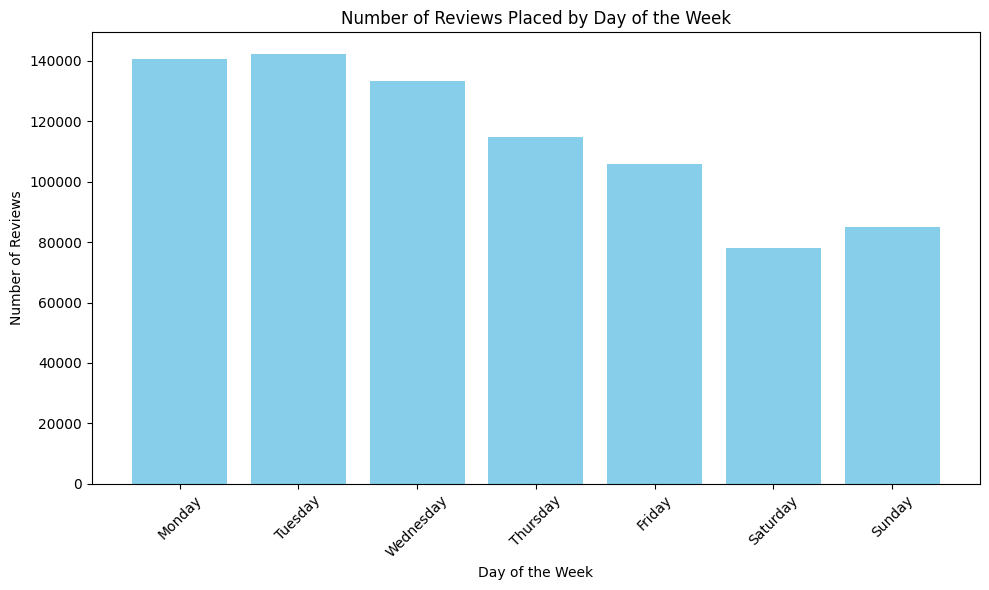

In [13]:
# Get the weekday (0: Monday, 1: Tuesday, ..., 6: Sunday)
weekdays = review_df['Date'].dt.dayofweek

# Count the occurrences of each weekday
weekday_counts = np.bincount(weekdays)

# Plot the distribution of reviews by day of the week
plt.figure(figsize=(10, 6))
plt.bar(range(7), weekday_counts, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Placed by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.tight_layout()
plt.show();

Most reviews were made on Tuesdays.

### Which movie has the highest average rating?

In [14]:
# extract review dates, user IDs, and ratings using NumPy
review_data = sample_tenth['review_data'].values
review_dates = np.concatenate([np.array([entry['date'] for entry in row]) for row in review_data])
user_ids = np.concatenate([np.array([entry['userId'] for entry in row]) for row in review_data])
ratings = np.concatenate([np.array([entry['rating'] for entry in row]) for row in review_data])

# Convert review_dates to pandas datetime objects
review_dates = pd.to_datetime(review_dates)

# Extract movie titles
titles = np.concatenate([[title] * len(row) for title, row in zip(sample_tenth['title'], review_data)])

# Create a DataFrame with review dates, user IDs, ratings, and movie titles
review_df = pd.DataFrame({'Date': review_dates, 'User_ID': user_ids, 'Rating': ratings, 'Movie_Title': titles})

In [15]:
review_df.groupby('Movie_Title')['Rating'].mean().sort_values(ascending=False).head(10)
print('{} is the best rated movie on average in this sample.'.format(review_df.groupby('Movie_Title')['Rating'].mean().idxmax()))

Movie_Title
Full Metal Panic FUMOFFU                4.451456
Toy Story                               4.353146
Law & Order: Season 3                   4.223117
Aqua Teen Hunger Force: Vol. 1          4.168650
Star Trek: Deep Space Nine: Season 5    4.160759
Absolutely Fabulous: Series 5           4.154367
Invader Zim                             4.142599
Apocalypse Now Redux                    4.138324
Star Trek: Voyager: Season 5            4.111377
The X-Files: Season 4                   4.097232
Name: Rating, dtype: float64

Full Metal Panic FUMOFFU is the best rated movie on average in this sample.


In [16]:
# see which movie has received the most amount of reviews and how many unique users have reviewed a movie
review_df['Movie_Title'].value_counts().head(10)
print('{} has received the highest amount of reviews in this sample.'.format(review_df['Movie_Title'].value_counts().idxmax()))
review_df.groupby('Movie_Title')['User_ID'].nunique().sort_values(ascending=False).head(10)
print('Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.')

Movie_Title
Something's Gotta Give                 118413
Overboard                               58536
Harold and Kumar Go to White Castle     47651
Apocalypse Now Redux                    41128
The Deer Hunter                         35509
True Romance                            35416
Breakfast at Tiffany's                  33731
Welcome to Mooseport                    27895
Blue Streak                             26774
Alice in Wonderland                     24889
Name: count, dtype: int64

Something's Gotta Give has received the highest amount of reviews in this sample.


Movie_Title
Something's Gotta Give                 118413
Overboard                               58536
Harold and Kumar Go to White Castle     47651
Apocalypse Now Redux                    41128
The Deer Hunter                         35509
True Romance                            35416
Breakfast at Tiffany's                  33731
Welcome to Mooseport                    27895
Blue Streak                             26774
Alice in Wonderland                     24889
Name: User_ID, dtype: int64

Above, the unique users that gave a review per movie is computed. The values match up exactly with the amount of reviews per movie, indicating no user has reviewed a movie twice.


### Handle outliers/distributions:

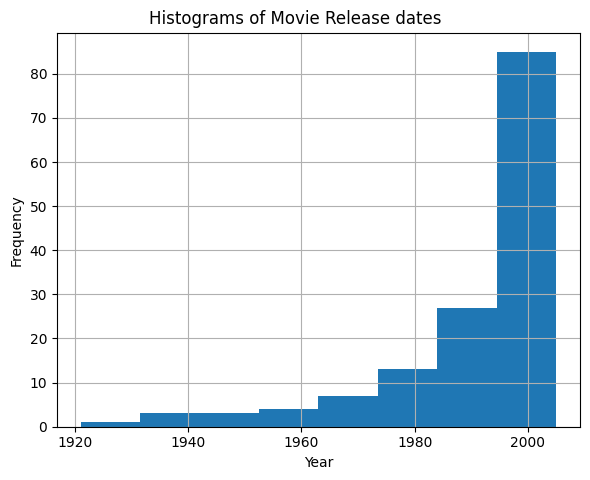

In [17]:
# Plot histogram with bins spanning 10 years
sample_tenth['year'] = sample_tenth['year'].astype(int)
plt.figure(figsize=(6, 5))
sample_tenth['year'].hist(bins=int((sample_tenth['year'].max() - sample_tenth['year'].min()) / 10), figsize=(6, 5))
plt.suptitle('Histograms of Movie Release dates', y=0.95)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

Data is skewed, as most records are released during the 90s and 00s.

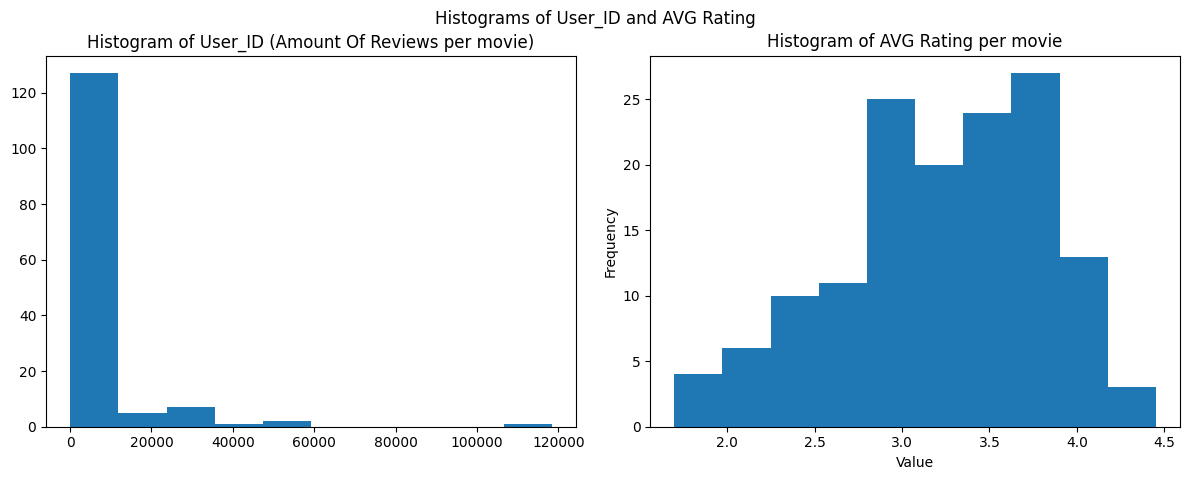

In [18]:
# Group by 'Movie_Title' and calculate count of User_ID and mean of Rating
result_df = review_df.groupby('Movie_Title').agg({'User_ID': 'count', 'Rating': 'mean'}).reset_index()

# Plot histograms for 'User_ID' and 'Rating'
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for 'User_ID'
axs[0].hist(result_df['User_ID'])
axs[0].set_title('Histogram of User_ID (Amount Of Reviews per movie)')

# Histogram for 'Rating'
axs[1].hist(result_df['Rating'])
axs[1].set_title('Histogram of AVG Rating per movie')

# Setting common attributes
plt.suptitle('Histograms of User_ID and AVG Rating', y=0.95)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

In [19]:
result_df

,Movie_Title,User_ID,Rating
0,100 Days Before the Command,83,2.144578
1,2 Days in the Valley,6605,3.291900
2,30 Years to Life,732,2.923497
3,A Kiss Before Dying,577,3.025997
4,A Perfect World,9856,3.459619
...,...,...,...
138,Welcome to Mooseport,27895,3.081412
139,West Hollywood Stories,493,1.697769
140,William S. Burroughs: Commissioner of Sewers,149,2.926174
141,Wire in the Blood: Justice Painted Blind,962,3.965696


Amount of reviews is highly skewed, indicating lots of movies with low amounts to no reviews.

AVG Rating is normally distributed, meaning the ratings across movies in the dataset are normally deviating around the mean.

### **Outliers**

Outliers in amount of reviews and release date will not be removed, as they represent users connected to those movies. Those represent a real-world variability which cannot be excluded. 

Furthermore, robust recommender systems should be able to adapt to these outliers and represent valuable information to those users as well. Removing this information would also mean that the model cannot be trained on those.

As the user-item matrix will be sparse, removing outliers would further reduce the size of the data which the model can use to train, which would make it more challenging to build a reliable recommender system.

## Check for timeseries association with ratings:

Hypothese before doing ANOVA:

- **H0**: means of groups across months of the year are **equal**, meaning there **IS NO** correlation between the time of the year and the avg. rating.
- **Ha**: means of groups across months of the year are **NOT equal**, meaning there **IS** correlation between the time of the year and the avg. rating.

In [20]:
# force data into category format and change to month notation to compare months with avg rating
df_anova = review_df[['Date', 'User_ID', 'Rating', 'Movie_Title']]
df_anova['Date'] = (df_anova['Date'].dt.strftime('%B')).astype('category')
df_anova

,Date,User_ID,Rating,Movie_Title
0,April,68845,3.0,Cold Blooded
1,May,349975,3.0,Cold Blooded
2,June,1619594,3.0,Cold Blooded
3,July,2377588,2.0,Cold Blooded
4,February,1361044,1.0,Cold Blooded
...,...,...,...,...
799640,November,773753,4.0,Apocalypse Now Redux
799641,November,2447982,4.0,Apocalypse Now Redux
799642,November,208255,4.0,Apocalypse Now Redux
799643,November,1352307,5.0,Apocalypse Now Redux


In [21]:
alpha = 0.05 # set confidence level at 95%

# Perform ANOVA
f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

if p_value < alpha:
    print("Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.")
else:
    print("Enough evidence to retain H0, so H0 will be applied and Ha dropped, meaning months of the year DO NOT have significant correlation with the avg. reviews per movie.")

F-Statistic: 116.65811751730452
P-value: 3.0570434732888035e-268
Not enough evidence to retain H0, so H0 will be dropped and Ha applies, meaning months of the year have significant correlation with the avg. reviews per movie.


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_11716\3653377720.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  f_statistic, p_value = f_oneway(*[group['Rating'] for _, group in df_anova.groupby('Date')])


#### Check assumptions ANOVA:

**Normality residuals assumption check:**

Residuals are not normally distributed (normality assumption may be violated).


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_11716\855064557.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in sample_df.groupby('Date'):


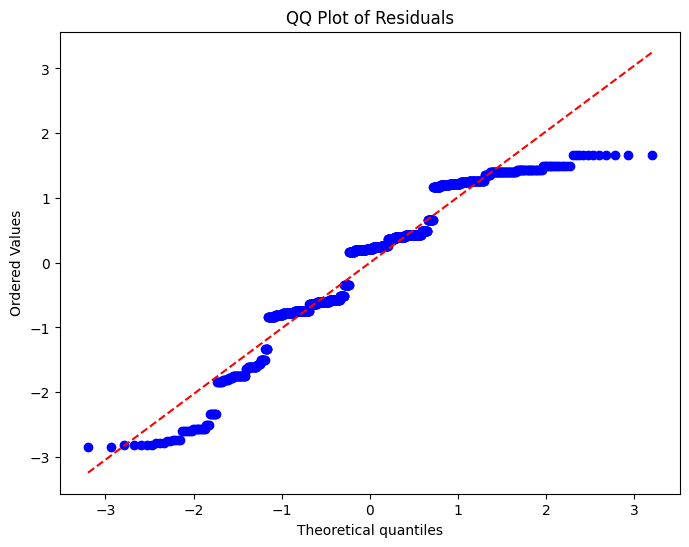

In [22]:
from scipy.stats import shapiro, levene
import scipy.stats as stats

# Get a random sample of 1000 observations from df_anova to get a accurate result in shaprio and levene test
sample_df = df_anova.sample(n=1000, random_state=42)

# Get residuals
residuals = []
for _, group in sample_df.groupby('Date'):
    residuals.extend(group['Rating'] - group['Rating'].mean())

# QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[1].set_linestyle('--')  # Add a dashed line to compare against normal distribution
ax.set_title('QQ Plot of Residuals')
plt.show();

In [25]:
# Shapiro-Wilk test for normality
_, shapiro_p_value = shapiro(residuals)
if shapiro_p_value > alpha:
    print("Residuals are normally distributed (normality assumption is met).")
else:
    print("Residuals are not normally distributed (normality assumption may be violated).")

Residuals are not normally distributed (normality assumption may be violated).


The variances are approximately lineair in the QQ-plot, even though the gaps between the groups suggest deviations in normality. Therefore, there is evidence to suggest that this assumption of ANOVA is not violated and that the residuals follow a normal distribution. The Shapiro test says otherwise, meaning this violation is violated.

**Homogeneity of variances assumption check:**

In [28]:
# Levene's test for homogeneity of variances
levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])
if levene_p_value > alpha:
    print("Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).")
else:
    print("Variances of residuals are not equal across all groups (homogeneity of variances assumption may be violated).")

Variances of residuals are approximately equal across all groups (homogeneity of variances assumption is met).


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_11716\865908296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene_statistic, levene_p_value = levene(*[group['Rating'] for _, group in sample_df.groupby('Date')])


As the residuals assumption is violated, the kruskal wallis test is needed to further investigate the validity of ANOVA results:

In [29]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test
kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])

print("Kruskal-Wallis Statistic:", kruskal_statistic)
print("P-value:", kruskal_p_value)

alpha = 0.05 # Set confidence level at 95%
if kruskal_p_value < alpha:
    print("Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.")
else:
    print("Fail to reject the null hypothesis. There IS NOT enough evidence to suggest that there are significant differences between the groups across months of the year. Therefore, there is NOT enough evidence to suggest month of the year has significant correlation with avg. rating.")


C:\Users\SJYHa\AppData\Local\Temp\ipykernel_11716\1833443547.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kruskal_statistic, kruskal_p_value = kruskal(*[group['Rating'] for _, group in df_anova.groupby('Date')])


Kruskal-Wallis Statistic: 1355.5965731921442
P-value: 4.570127121143542e-284
Reject the null hypothesis. There is enough evidence to suggest that there are significant differences between the groups. Therefore, there IS enough evidence to suggest month of the year has significant correlation with avg. rating.


## Handle null values:

Already handled in the joining.ipynb file. There are no null values in the Netflix Prize Dataset to handle.